## CNN based learning anomaly patterns

In [58]:
%reload_ext autoreload
%autoreload 2

In [43]:
from collections import defaultdict
from multiprocessing import cpu_count

import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset

import scipy.stats
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 7
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = True

import warnings
warnings.filterwarnings('ignore')

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed = 1
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

In [51]:
import pathlib
from sklearn.preprocessing import minmax_scale
from scipy.stats import zscore

class TSDatasetAnomalyPatterns(Dataset):
    def __init__(self, path: pathlib.Path, without_anomaly_position: bool = False, downsampling: int = 1, scaling: str = "minmax"):
        super(TSDatasetAnomalyPatterns, self).__init__()
        self.df = pd.read_json(str(path), orient='records', lines=True)

        def preprocess(x):
            x = np.array(x)
            x = np.mean(x.reshape(-1, downsampling), axis=1) if downsampling > 1 else x
            # standarlize max/min  {1, 0}
            match scaling:
                case "minmax":
                    return minmax_scale(x, feature_range=(0, 1))
                case "zscore":
                    return zscore(x)
                case _:
                    assert False, f"Unknown scaling: {scaling}"
                
        self.time_series = torch.tensor([
            self.df.loc[:, "time_series"].apply(lambda x: preprocess(x))
        ], dtype=torch.float32)  # use float64 to avoid error

        # def _join_category(x):
        #     if x["anomaly_pattern"] in ["Sudden increase", "Sudden decrease"]:
        #         return x["anomaly_pattern"]
        #     return "/".join(x.dropna().astype(str).values)

        self.joined_categories = self.df.loc[:, ["anomaly_pattern", "anomaly_position"]].apply(
            lambda x: "/".join(x.dropna().astype(str).values), axis=1
        ).to_numpy() if not without_anomaly_position else self.df.loc[:, "anomaly_pattern"].to_numpy()

        # string labels to int labels
        self.label_to_category = {i: v for i, v in enumerate(np.unique(self.joined_categories))}
        category_to_label = {v: k for k, v in self.label_to_category.items()}
        self.labels = torch.tensor([
            category_to_label[c] for c in self.joined_categories
        ], dtype=torch.int64)

    def __getitem__(self, idx):
        label = self.labels[idx]
        category = self.label_to_category[label.item()]
        return self.time_series[:, idx], label, category

    def __len__(self):
        return len(self.df)

    def number_of_class(self) -> int:
        return len(self.label_to_category.keys())
    
    def categories(self) -> set[str]:
        return set(self.label_to_category.values())

In [53]:
import torch.utils.data
from sklearn.model_selection import train_test_split


dataset = TSDatasetAnomalyPatterns(pathlib.Path("../samples/tsdr_anomaly_patterns/labeled_tsdr_anomaly_patterns_20221210-145911.jsonl"), downsampling=1, scaling="minmax")
print(dataset.number_of_class(), len(dataset.categories()))
display(dataset.label_to_category)
display(dataset.df.groupby(["anomaly_pattern", "anomaly_position"]).size().sort_values(ascending=False))

train_indices, test_indices = train_test_split(list(range(len(dataset.labels))), test_size=0.2, stratify=dataset.labels.tolist())
train_dataset = torch.utils.data.Subset(dataset, train_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

print(f"train size {len(train_dataset)}, test size {len(test_dataset)}")

23 23


{0: 'Fluctuations/anomaly_during_fault',
 1: 'Level shift down/anomaly_during_fault',
 2: 'Level shift down/anomaly_outside_fault',
 3: 'Level shift up/anomaly_during_fault',
 4: 'Level shift up/anomaly_outside_fault',
 5: 'Multiple dips/anomaly_outside_fault',
 6: 'Multiple spikes/anomaly_during_fault',
 7: 'Multiple spikes/anomaly_outside_fault',
 8: 'Other normal/no_anomaly',
 9: 'Single dip/anomaly_during_fault',
 10: 'Single dip/anomaly_outside_fault',
 11: 'Single spike/anomaly_during_fault',
 12: 'Single spike/anomaly_outside_fault',
 13: 'Steady decrease/anomaly_during_fault',
 14: 'Steady increase/anomaly_during_fault',
 15: 'Sudden decrease/anomaly_during_fault',
 16: 'Sudden decrease/anomaly_outside_fault',
 17: 'Sudden increase/anomaly_during_fault',
 18: 'Transient level shift down/anomaly_during_fault',
 19: 'Transient level shift down/anomaly_outside_fault',
 20: 'Transient level shift up/anomaly_during_fault',
 21: 'Transient level shift up/anomaly_outside_fault',
 22: 

anomaly_pattern             anomaly_position     
White noise                 no_anomaly               284
Other normal                no_anomaly               133
Level shift down            anomaly_during_fault     130
Transient level shift down  anomaly_during_fault     116
Single spike                anomaly_during_fault     113
Level shift up              anomaly_during_fault      96
Single dip                  anomaly_during_fault      83
Transient level shift up    anomaly_during_fault      76
Single spike                anomaly_outside_fault     67
Level shift down            anomaly_outside_fault     58
Steady decrease             anomaly_during_fault      49
Multiple spikes             anomaly_outside_fault     46
Sudden increase             anomaly_during_fault      45
Steady increase             anomaly_during_fault      39
Fluctuations                anomaly_during_fault      39
Level shift up              anomaly_outside_fault     38
Transient level shift up    anomaly_ou

train size 1218, test size 305


In [59]:
from torchinfo import summary

from diagnoser.cnn_model import CNN1d

model = CNN1d(num_classes=dataset.number_of_class()).to(device)
learning_rate = 0.001
epochs = 10
batch_size = 4
test_batch_size = 4
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

summary(model, input_size=(batch_size, 1, 180))

Layer (type:depth-idx)                   Output Shape              Param #
CNN1d                                    [4, 23]                   --
├─Conv1d: 1-1                            [4, 64, 177]              320
├─Conv1d: 1-2                            [4, 128, 84]              32,896
├─Conv1d: 1-3                            [4, 256, 38]              131,328
├─Dropout: 1-4                           [4, 4608]                 --
├─Linear: 1-5                            [4, 64]                   294,976
├─BatchNorm1d: 1-6                       [4, 64]                   128
├─Dropout: 1-7                           [4, 64]                   --
├─Linear: 1-8                            [4, 23]                   1,495
Total params: 461,143
Trainable params: 461,143
Non-trainable params: 0
Total mult-adds (M): 32.43
Input size (MB): 0.00
Forward/backward pass size (MB): 1.02
Params size (MB): 1.84
Estimated Total Size (MB): 2.87

In [67]:
from dataclasses import dataclass, field

@dataclass
class ScoreHistory:
    train_loss_values: list[float] = field(default_factory=list)
    train_acc_values: list[float] = field(default_factory=list)
    test_loss_values: list[float] = field(default_factory=list)
    test_acc_values: list[float] = field(default_factory=list)
    epochs: int = 0

    def latest_loss_pair(self) -> tuple[float, float]:
        return self.train_loss_values[-1], self.test_loss_values[-1]

    def latest_acc_pair(self) -> tuple[float, float]:
        return self.train_acc_values[-1], self.test_acc_values[-1]

    def append_train(self, loss: float, acc: float):
        self.train_loss_values.append(loss)
        self.train_acc_values.append(acc)
    
    def append_test(self, loss: float, acc: float):
        self.test_loss_values.append(loss)
        self.test_acc_values.append(acc)
    
    def loss(self, sum_loss, batch_size: int, data_size: int) -> float:
        return sum_loss * batch_size / data_size
    
    def plots(self):
        fig = plt.figure(tight_layout=True, figsize=(7, 3))
        axs = fig.subplots(nrows=1, ncols=2)
        ax_loss, ax_acc = axs[0], axs[1]
        for title, ax, train_values, test_values in zip(("loss", "accuracy"), (ax_loss, ax_acc), (self.train_loss_values, self.train_acc_values), (self.test_loss_values, self.test_acc_values)):
            ax.set_title(title)
            if len(train_values) > 0:
                ax.plot(range(self.epochs), train_values)
            if len(test_values) > 0:
                ax.plot(range(self.epochs), test_values, c='#00ff00')
            ax.set_xlim(0, self.epochs)
            ax.set_ylim(0, max(train_values + test_values) + 0.1)
            ax.set_xlabel("epoch")
            ax.set_ylabel(title)
            ax.legend([f"train {title}", f"test {title}"])
        return fig


from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns


@dataclass
class PredictionResult:
    categories: set[str]
    target_labels: list[int] = field(default_factory=list)
    pred_labels: list[int] = field(default_factory=list)

    def append(self, _pred_labels: list[int], _target_labels: list[int]):
        self.target_labels += _target_labels
        self.pred_labels += _pred_labels

    def confusion_matrix(self, normalized=True):
        cm = confusion_matrix(self.target_labels, self.pred_labels)
        if normalized:
            return cm / cm.sum(axis=1, keepdims=True)
        return cm
    
    def labels_of_bin_class(self) -> tuple[list[int], list[int]]:
        class_to_bin_class: dict[int, int] = {}
        for i, c in enumerate(self.categories):
            if c.startswith("Other normal") or c.startswith("White noise"):
                class_to_bin_class[i] = 0  # Normal class
            else:
                class_to_bin_class[i] = 1  # Anomaly class
        bin_target_labels = list(map(lambda x: class_to_bin_class[x], self.target_labels))
        bin_pred_labels = list(map(lambda x: class_to_bin_class[x], self.pred_labels))
        return bin_target_labels, bin_pred_labels
    
    def confusion_matrix_as_bin_class(self, normalized=True):
        bin_target_labels, bin_pred_labels = self.labels_of_bin_class()
        cm = confusion_matrix(bin_target_labels, bin_pred_labels)
        if normalized:
            return cm / cm.sum(axis=1, keepdims=True)
        return cm
    
    def score_of_bin_class(self) -> tuple[float, float, float, float]:
        bin_target_labels, bin_pred_labels = self.labels_of_bin_class()
        acc = accuracy_score(bin_target_labels, bin_pred_labels)
        precision = precision_score(bin_target_labels, bin_pred_labels)
        recall = recall_score(bin_target_labels, bin_pred_labels)
        f1 = f1_score(bin_target_labels, bin_pred_labels)
        return acc, precision, recall, f1
    
    def score_of_bin_class_as_df(self) -> pd.DataFrame:
        acc, precision, recall, f1 = self.score_of_bin_class()
        return pd.DataFrame(
            data=[[acc, precision, recall, f1]],
            columns=["accuracy", "precision", "recall", "f1"],
            index=["score"],
        )
    
    def plot(self):
        fig = plt.figure(tight_layout=True, figsize=(18, 18))
        ax = fig.subplots(nrows=1, ncols=1)
        ax.tick_params(pad=2)
        ax.tick_params(bottom="off", top="off")
        ax.tick_params(left="off")
        ax.tick_params(bottom=False, left=False, right=False, top=False)
        ax = sns.heatmap(
            data=self.confusion_matrix(), cmap='Blues', annot=True, annot_kws={"fontsize": 11}, fmt='.2f',
            linewidths=.2, linecolor="lightgray", square=True, cbar=False,
            cbar_kws={"drawedges": True}, ax=ax,
        )
        ax.set_xticks(np.arange(len(self.categories)))
        ax.set_yticks(np.arange(len(self.categories)))
        ax.set_xticklabels(self.categories, fontsize=7, rotation=45)
        ax.set_yticklabels(self.categories, fontsize=7, rotation=45, va='top')
        ax.set_xlabel("Predict Label", fontsize=12)
        ax.set_ylabel("Target Label", fontsize=12)

    def plot_as_anomaly_or_not(self):
        fig = plt.figure(tight_layout=True, figsize=(5, 2))
        ax = fig.subplots(nrows=1, ncols=1)
        ax.tick_params(pad=2)
        ax.tick_params(bottom="off", top="off")
        ax.tick_params(left="off")
        ax.tick_params(bottom=False, left=False, right=False, top=False)
        ax = sns.heatmap(
            data=self.confusion_matrix_as_bin_class(), square=True, cmap='Blues',
            annot=True, annot_kws={"fontsize": 9}, fmt='.2f',
            linewidths=.2, linecolor="lightgray", cbar=False,
            cbar_kws={"drawedges": True}, ax=ax,
        )
        _agg_categories = ["Normal", "Anomaly"]
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        ax.set_xticklabels(_agg_categories, fontsize=7)
        ax.set_yticklabels(_agg_categories, fontsize=7)
        ax.set_xlabel("Predict Label", fontsize=9)
        ax.set_ylabel("Target Label", fontsize=9)


def train(model, device, train_loader, optimizer, loss_fn):
    model.train()
    for data, target, category in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output, proba = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()


def test_train_data(model, device, train_loader, loss_fn, score_history: ScoreHistory):
    model.eval()
    loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for data, target, category in train_loader:
            data, target = data.to(device), target.to(device)
            output, proba = model(data)
            loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
    
    loss = score_history.loss(loss, len(train_loader), len(train_loader.dataset)) 
    score_history.append_train(
        loss=loss,
        acc=correct / total,
    )

    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        loss, correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)))
    

def test(model, device, test_loader, loss_fn, score_history: ScoreHistory, pred_res: PredictionResult):
    model.eval()
    loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for data, target, category in test_loader:
            data, target = data.to(device), target.to(device)
            output, proba = model(data)
            loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            pred_proba = proba.max(dim=1, keepdim=True)[0]
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
            
            pred_res.append(pred.view_as(target).tolist(), target.tolist())

    loss = score_history.loss(loss, len(test_loader), len(test_loader.dataset)) 
    score_history.append_test(
        loss=loss, 
        acc=correct / total,
    )

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

Split dataset as train and test set.

  0%|          | 0/32 [00:00<?, ?it/s]

Train set: Average loss: 8.1035, Accuracy: 626/1218 (51%)
Test set: Average loss: 2.3002, Accuracy: 140/305 (46%)
Train set: Average loss: 5.7945, Accuracy: 793/1218 (65%)
Test set: Average loss: 1.6479, Accuracy: 173/305 (57%)
Train set: Average loss: 3.8230, Accuracy: 952/1218 (78%)
Test set: Average loss: 1.2282, Accuracy: 222/305 (73%)
Train set: Average loss: 3.7204, Accuracy: 909/1218 (75%)
Test set: Average loss: 1.1569, Accuracy: 210/305 (69%)
Train set: Average loss: 3.5386, Accuracy: 970/1218 (80%)
Test set: Average loss: 1.1773, Accuracy: 226/305 (74%)
Train set: Average loss: 2.3187, Accuracy: 1037/1218 (85%)
Test set: Average loss: 0.8195, Accuracy: 238/305 (78%)
Train set: Average loss: 1.8753, Accuracy: 1076/1218 (88%)
Test set: Average loss: 0.8119, Accuracy: 233/305 (76%)
Train set: Average loss: 2.2893, Accuracy: 998/1218 (82%)
Test set: Average loss: 0.9012, Accuracy: 230/305 (75%)
Train set: Average loss: 1.6605, Accuracy: 1093/1218 (90%)
Test set: Average loss: 0.7

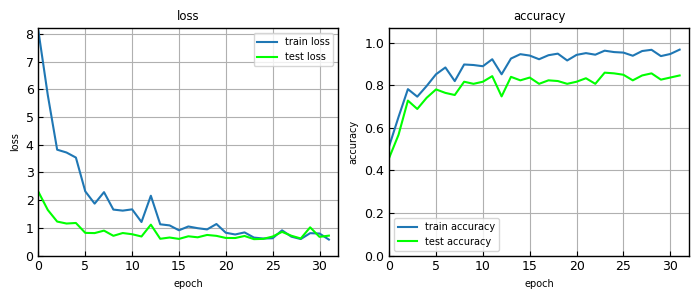

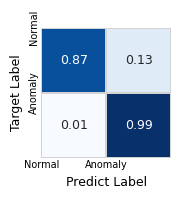

,accuracy,precision,recall,f1
score,0.978176,0.988168,0.988058,0.988113


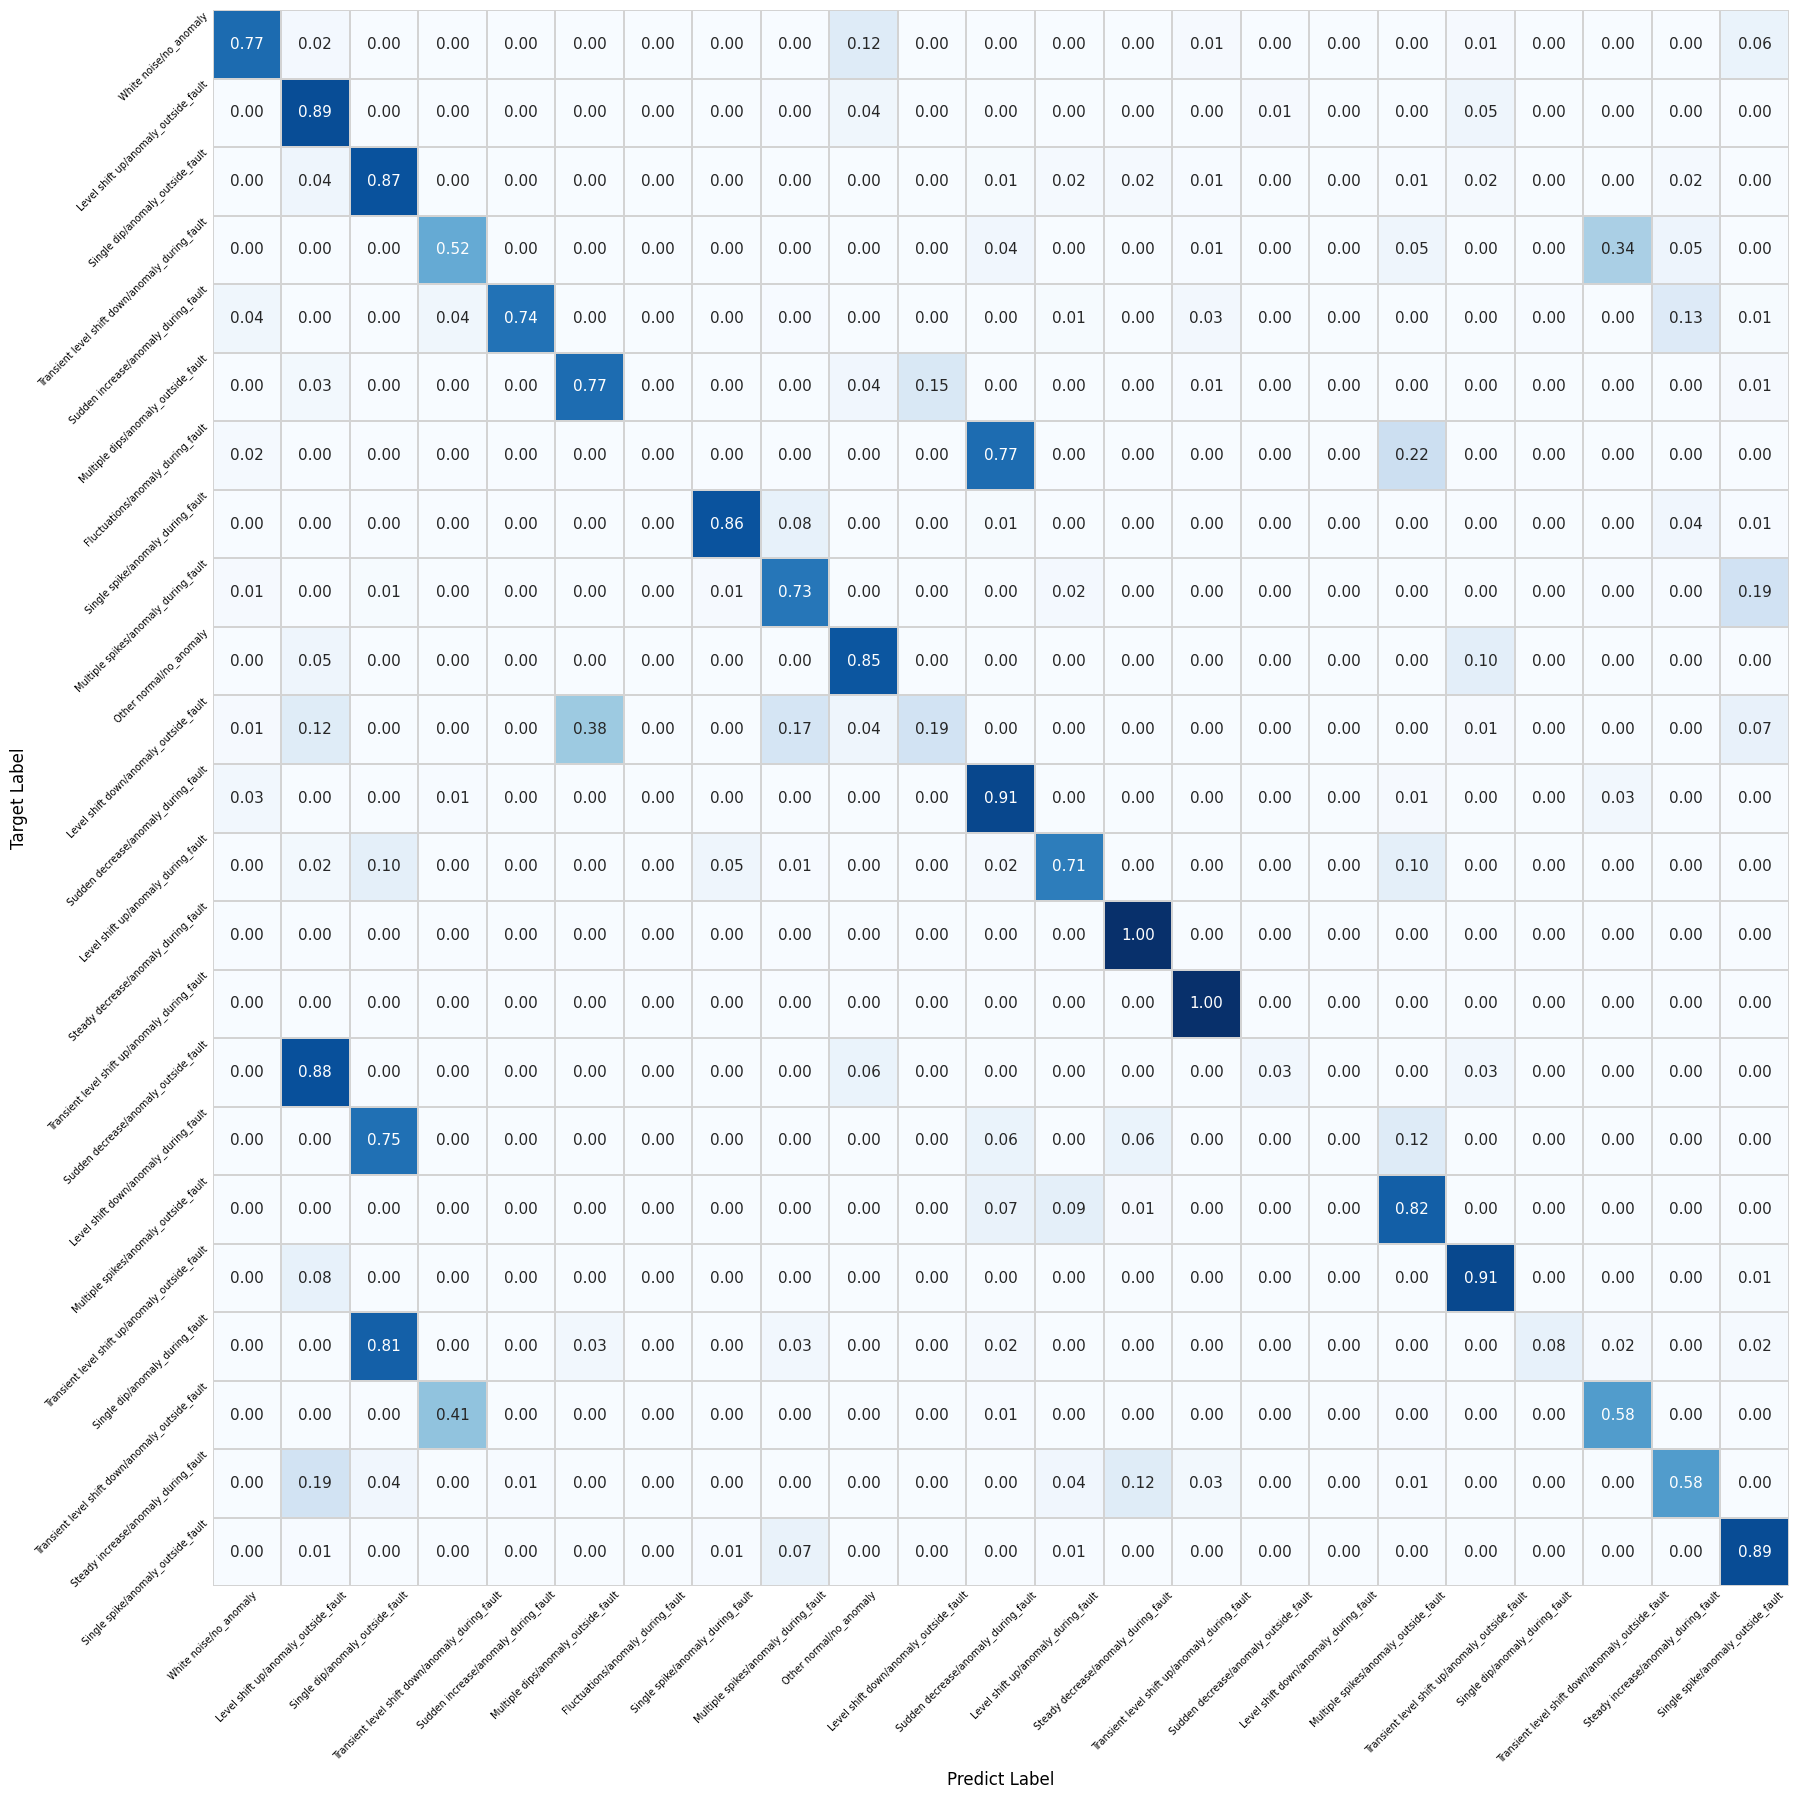

In [38]:
from collections import OrderedDict

from tqdm.notebook import tqdm

from diagnoser.cnn_model import CNN1d


model = CNN1d(num_classes=dataset.number_of_class()).to(device)
learning_rate = 0.001
epochs = 32
batch_size = 16
test_batch_size = 16
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True, pin_memory=True)

score_hist = ScoreHistory(epochs=epochs)
pred_res = PredictionResult(categories=dataset.categories())

with tqdm(range(1, epochs + 1)) as pbar_epochs:
    for epoch in pbar_epochs:
        pbar_epochs.set_description(f"[Epoch {epoch}]")

        train(model, device, train_dataloader, optimizer, loss_fn)
        test_train_data(model, device, train_dataloader, loss_fn, score_hist)
        test(model, device, test_dataloader, loss_fn, score_hist, pred_res)
        train_loss, test_loss = score_hist.latest_loss_pair()
        train_acc, test_acc = score_hist.latest_acc_pair()
        pbar_epochs.set_postfix(OrderedDict(
            train_loss=train_loss, test_loss=test_loss,
            train_acc=train_acc, test_acc=test_acc,
        ))

score_hist.plots()
plt.show()
pred_res.plot_as_anomaly_or_not()
plt.show()
display(pred_res.score_of_bin_class_as_df())
pred_res.plot()
plt.show()

### Save model

In [10]:
torch.save(model, "models/current_best_cnn1d.pt")

In [41]:
current_best_model = torch.load("models/current_best_cnn1d.pt")
summary(current_best_model, input_size=(batch_size, 1, 180))
torch.save(current_best_model.state_dict(), "models/current_best_cnn1d.pth")

## Learning without anomaly positon label

In [62]:
dataset_without_ap = TSDatasetAnomalyPatterns(
    # pathlib.Path("../samples/tsdr_anomaly_patterns/labeled_tsdr_anomaly_patterns_20221210-145911.jsonl"),
    pathlib.Path("../samples/tsdr_anomaly_patterns/labeled_tsdr_anomaly_patterns_20221202-024759.jsonl"),
    without_anomaly_position=True,
)
print(dataset_without_ap.number_of_class(), len(dataset_without_ap.categories()))
display(dataset_without_ap.label_to_category)
display(dataset_without_ap.df.groupby(["anomaly_pattern"]).size().sort_values(ascending=False))

train_indices, test_indices = train_test_split(list(range(len(dataset_without_ap.labels))), test_size=0.2, stratify=dataset_without_ap.labels.tolist())
train_dataset = torch.utils.data.Subset(dataset_without_ap, train_indices)
test_dataset = torch.utils.data.Subset(dataset_without_ap, test_indices)

print(f"train size {len(train_dataset)}, test size {len(test_dataset)}")

15 15


{0: 'Fluctuations',
 1: 'Level shift down',
 2: 'Level shift up',
 3: 'Multiple dips',
 4: 'Multiple spikes',
 5: 'Other normal',
 6: 'Single dip',
 7: 'Single spike',
 8: 'Steady decrease',
 9: 'Steady increase',
 10: 'Sudden decrease',
 11: 'Sudden increase',
 12: 'Transient level shift down',
 13: 'Transient level shift up',
 14: 'White noise'}

anomaly_pattern
White noise                   267
Level shift down              155
Single spike                  133
Other normal                  127
Level shift up                100
Transient level shift up       68
Transient level shift down     63
Single dip                     54
Steady decrease                49
Multiple spikes                42
Steady increase                39
Fluctuations                   38
Multiple dips                  27
Sudden increase                26
Sudden decrease                 5
dtype: int64

train size 954, test size 239


  0%|          | 0/32 [00:00<?, ?it/s]

Train set: Average loss: 5.6114, Accuracy: 527/954 (55%)
Test set: Average loss: 1.4686, Accuracy: 129/239 (54%)
Train set: Average loss: 4.5370, Accuracy: 637/954 (67%)
Test set: Average loss: 1.1926, Accuracy: 153/239 (64%)
Train set: Average loss: 3.6209, Accuracy: 664/954 (70%)
Test set: Average loss: 0.9137, Accuracy: 165/239 (69%)
Train set: Average loss: 3.2424, Accuracy: 676/954 (71%)
Test set: Average loss: 0.8273, Accuracy: 168/239 (70%)
Train set: Average loss: 2.9629, Accuracy: 720/954 (75%)
Test set: Average loss: 0.7798, Accuracy: 180/239 (75%)
Train set: Average loss: 2.3705, Accuracy: 763/954 (80%)
Test set: Average loss: 0.6673, Accuracy: 187/239 (78%)
Train set: Average loss: 2.0918, Accuracy: 807/954 (85%)
Test set: Average loss: 0.6209, Accuracy: 197/239 (82%)
Train set: Average loss: 2.1645, Accuracy: 756/954 (79%)
Test set: Average loss: 0.6459, Accuracy: 181/239 (76%)
Train set: Average loss: 1.9213, Accuracy: 791/954 (83%)
Test set: Average loss: 0.6193, Accurac

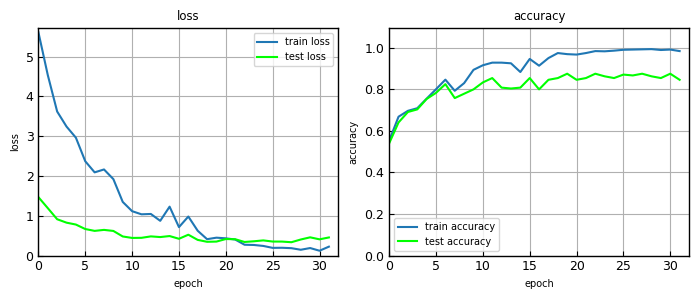

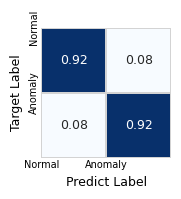

,accuracy,precision,recall,f1
score,0.919064,0.954365,0.919153,0.936428


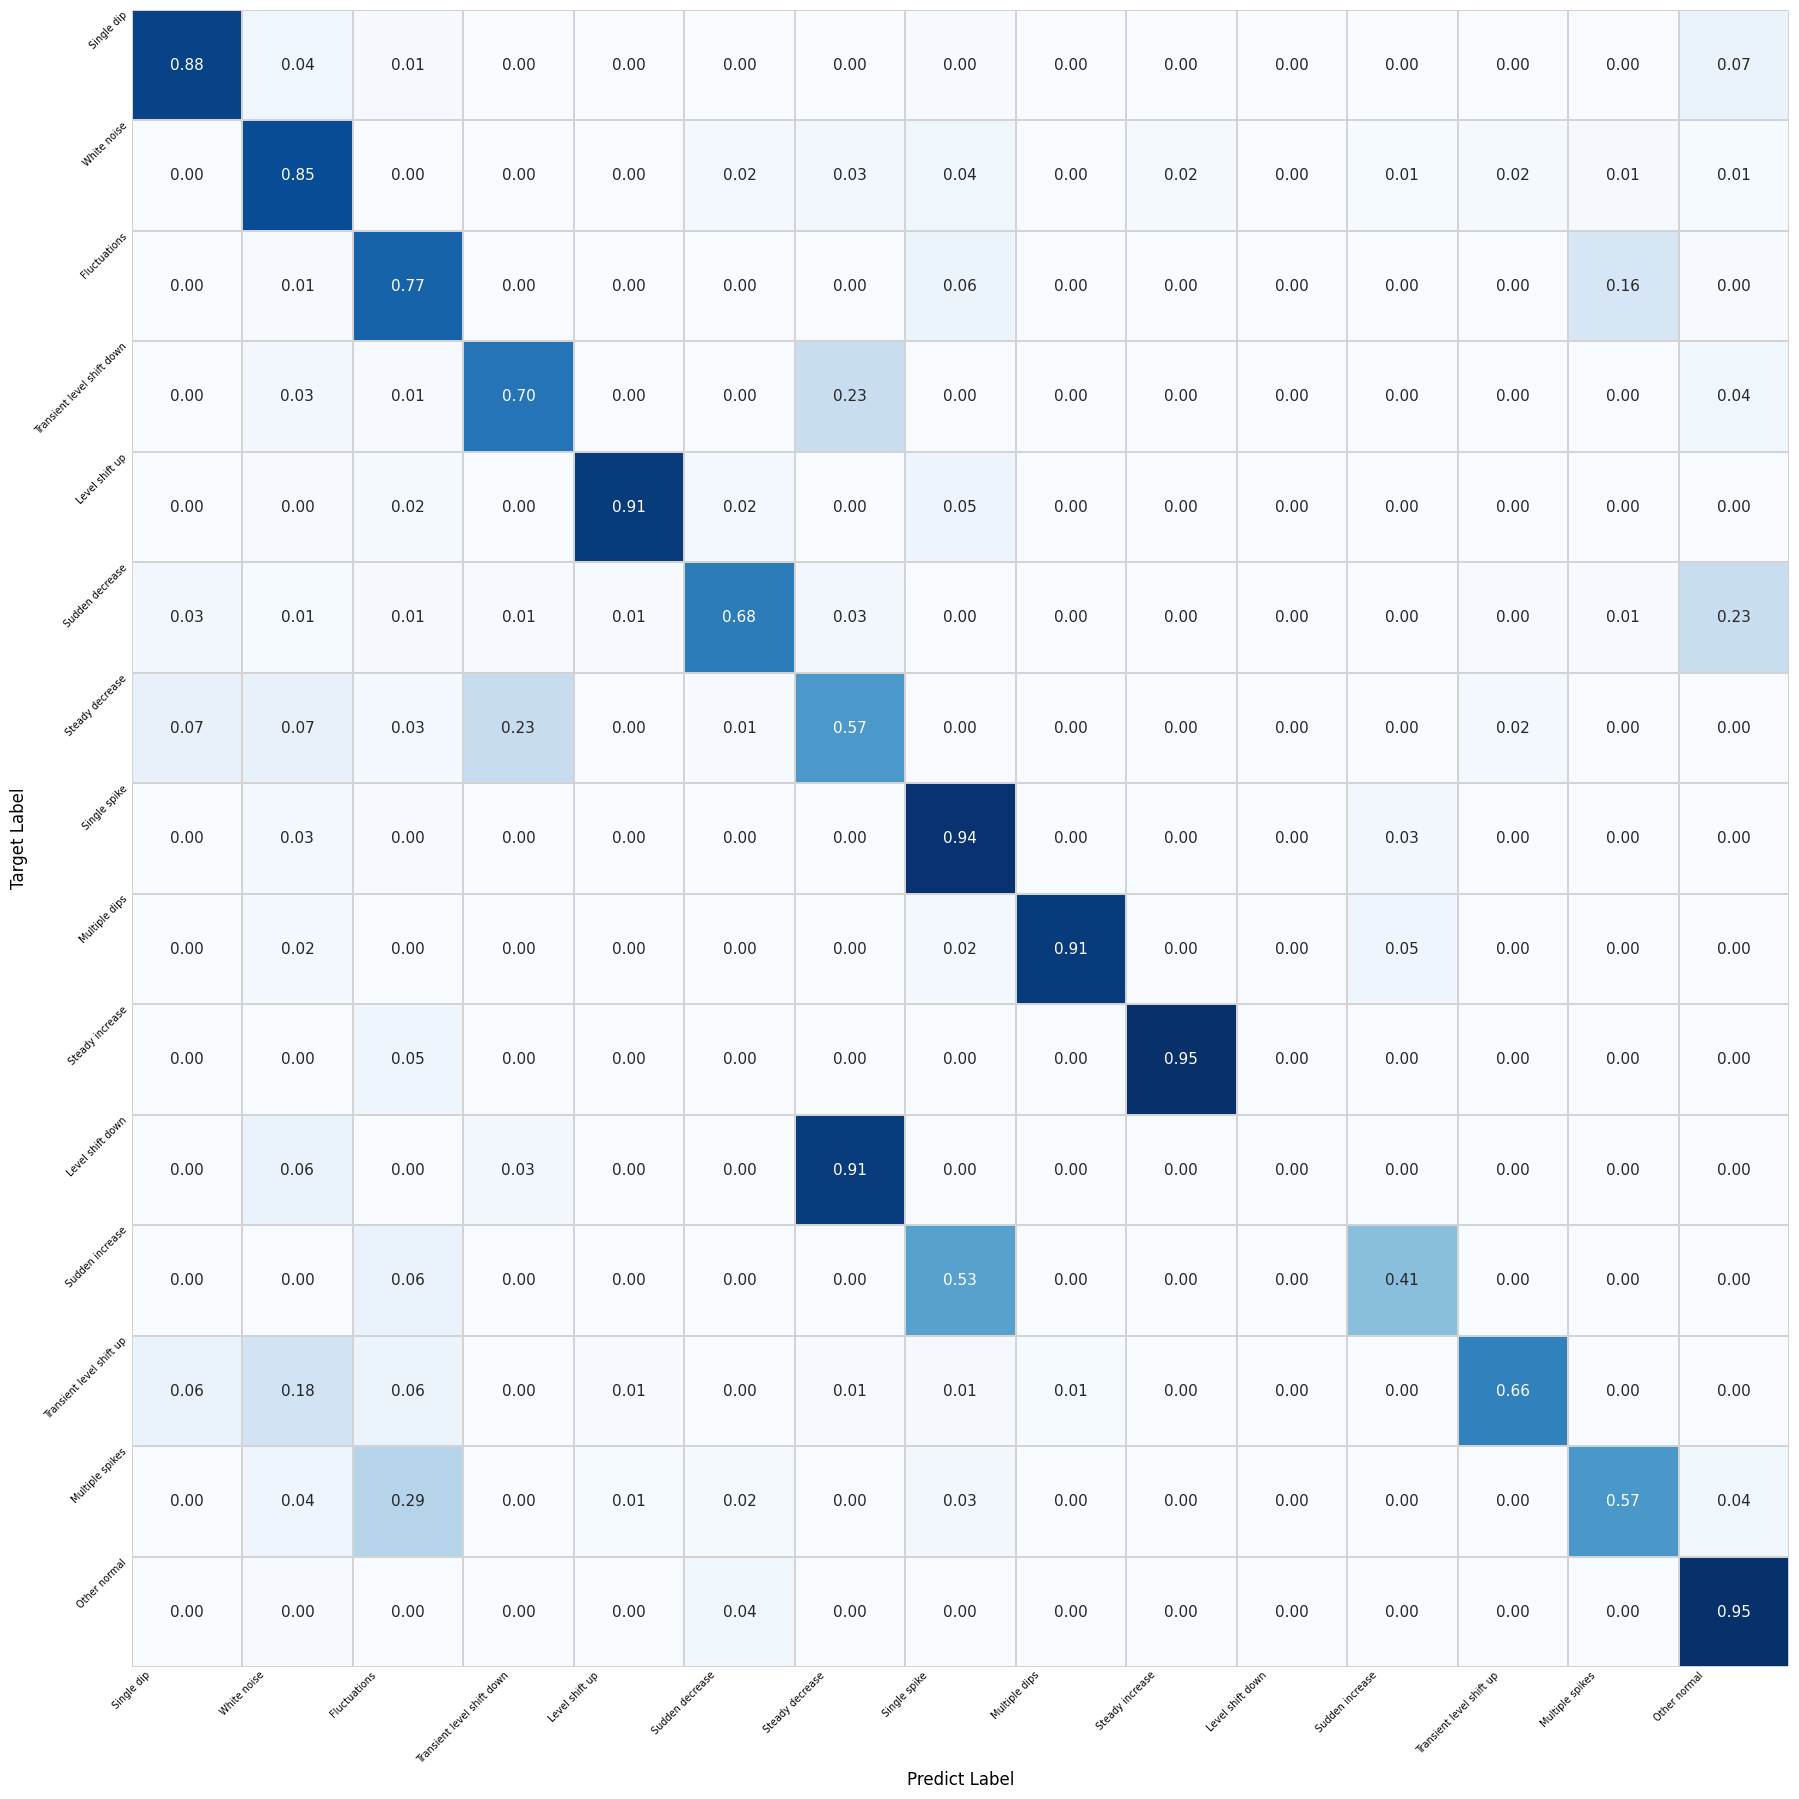

In [72]:
from diagnoser.cnn_model import CNN1d

model_without_ap = CNN1d(num_classes=dataset_without_ap.number_of_class()).to(device)
learning_rate = 0.001
epochs = 32
batch_size = 16
test_batch_size = 16
optimizer = optim.Adam(model_without_ap.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True, pin_memory=True)

score_hist = ScoreHistory(epochs=epochs)
pred_res = PredictionResult(categories=dataset_without_ap.categories())

with tqdm(range(1, epochs + 1)) as pbar_epochs:
    for epoch in pbar_epochs:
        pbar_epochs.set_description(f"[Epoch {epoch}]")

        train(model_without_ap, device, train_dataloader, optimizer, loss_fn)
        test_train_data(model_without_ap, device, train_dataloader, loss_fn, score_hist)
        test(model_without_ap, device, test_dataloader, loss_fn, score_hist, pred_res)
        train_loss, test_loss = score_hist.latest_loss_pair()
        train_acc, test_acc = score_hist.latest_acc_pair()
        pbar_epochs.set_postfix(OrderedDict(
            train_loss=train_loss, test_loss=test_loss,
            train_acc=train_acc, test_acc=test_acc,
        ))

score_hist.plots()
plt.show()
pred_res.plot_as_anomaly_or_not()
plt.show()
display(pred_res.score_of_bin_class_as_df())
pred_res.plot()
plt.show()

In [74]:
torch.save(model_without_ap.state_dict(), "models/current_best_cnn1d_without_ap.pth")